In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
#import Image
#from skimage import io

In [4]:
class Smallanimaldata(Dataset):
    def __init__(self,root,class_1,class_2,class_3,is_train):
        self.root=root
        self.class_1=class_1
        self.class_2=class_2
        self.class_3=class_3
        self.is_train = is_train
        #self.augment_pool = augment_pool()
        
        ######### dataset lists #################
        self.pathc=os.path.join(self.root,self.class_1)
        self.pathlistc=os.listdir(self.pathc)
        self.clas1=[]
        for lstcont in self.pathlistc:
            pathf=os.path.join(self.pathc,lstcont)
            self.clas1.append((pathf,0))
            
        self.pathc2=os.path.join(self.root,self.class_2)
        self.pathlistc2=os.listdir(self.pathc2)
        self.clas2=[]
        for lst2 in self.pathlistc2:
            pathfm=os.path.join(self.pathc2,lst2)
            self.clas2.append((pathfm,1))

        self.path3=os.path.join(self.root,self.class_3)
        self.pathlistc3=os.listdir(self.path3)
        self.clas3=[]
        for lst3 in self.pathlistc3:
            pathfm3=os.path.join(self.path3,lst3)
            self.clas3.append((pathfm3,2))
        # total list for class1 and class2
        self.totpath=self.clas1+self.clas2+self.clas3
        
    
        # for training
        if self.is_train:
            self.transform=transforms.Compose([transforms.ToPILImage(),
                                               transforms.Resize((224,224)),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=.05),
                                               transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                ])
        # for validation
        if not self.is_train:
            self.transform=transforms.Compose([transforms.ToPILImage(),
                                               transforms.Resize((224,224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                ])
            
            
    def __getitem__(self,idx):
        
        ################### Speech Dataset spectrum #################
        pathd,label=self.totpath[idx]
        #print(pathd)
        img=cv2.imread(pathd)
        img=self.transform(img)
        
        return {"im1":img,
                "labl1":label}
    
    
    def __len__(self):
        return len(self.totpath)

In [5]:
train_data2="/content/drive/MyDrive/ISblue_workshop/dataset/train"    
valid_data2="/content/drive/MyDrive/ISblue_workshop/dataset/val"

dataset_train=Smallanimaldata(train_data2,'class1','class2','class3',True)
dataset_valid=Smallanimaldata(valid_data2,'class1','class2','class3',False)
len(dataset_train)
len(dataset_valid)

train_loader=DataLoader(dataset_train,batch_size=12,shuffle=True)
valid_loader=DataLoader(dataset_valid,batch_size=12,shuffle=False) 
len(train_loader.dataset)
len(valid_loader.dataset)

66

In [6]:
################### define the models ###################### 
# pytorch petrained models for classification
def premodels(pretrained,model_selec,num_classes):
    
    if model_selec=="ResNetm":
        model_ft = models.resnet18(pretrained=pretrained)
        ## Modify fc layers to match num_classes
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
    
    elif model_selec=="DensNet":
        model_ft = models.densenet201(pretrained=pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier= nn.Linear(num_ftrs, num_classes)
        
    elif model_selec=="SENet":
        model_ft = models.squeezenet1_0(pretrained=pretrained)
        for params in list(model_ft.parameters())[0:-5]:
            params.requires_grad = False
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model=model_ft
    
    elif model_selec=="MobileNet":
        model_ft = models.mobilenet_v2(pretrained=pretrained)    
        # Freeze all the required layers (i.e except last conv block and fc layers)
        for params in list(model_ft.parameters())[0:-5]:
            params.requires_grad = False
        # Modify fc layers to match num_classes
        num_ftrs=model_ft.classifier[-1].in_features
        model_ft.classifier=nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                          nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True))
        model=model_ft
    
    
    elif model_selec=="VGG11":
        model_ft = models.vgg11_bn(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model=model_ft

    elif model_selec=="Efficents":
        from efficientnet_pytorch import EfficientNet
        model = EfficientNet.from_pretrained("efficientnet-b0")
        model._fc = nn.Sequential(nn.Linear(2560, 256),
                                  nn.Dropout(0.5),
                                  nn.ReLU(True),
                                  nn.Linear(256,num_classes),
                                  )
        
    elif model_selec=="Efficents2m":
        model=effnetv2_m()
        
    elif model_selec=="Efficents2s":
        model=effnetv2_s()
        
    elif model_selec=="Efficents2L":
        model=effnetv2_l()
        
    elif model_selec=="Efficents2XL":
        model=effnetv2_xl()
        
    # elif model_selec=="Efficents2m":
    #     model=effnetv2_m()

    else:
        print("no model available")
        
    return model_ft

In [9]:
model_ft=premodels(pretrained=True,model_selec="ResNetm",num_classes=3)        
#print(model)   
model_ft.to(device)
model=model_ft

In [10]:
###################### define loss function and optimzer ############
loss_func=nn.CrossEntropyLoss()
import torch.optim as optim
optimizer=optim.Adam(model.parameters(),lr=0.0001)

In [11]:
################################ training functions ###################
def train_fn(model,train_loader):
    model.train()
    counter=0
    training_run_loss=0.0
    train_running_correct=0.0
    for i, data in tqdm(enumerate(train_loader),total=int(len(dataset_train)/train_loader.batch_size)):
        counter+=1
        # extract dataset
        imge,label=data["im1"],data["labl1"]
        imge=imge.to(device)
        label=label.to(device)
        # zero_out the gradient
        optimizer.zero_grad()
        output=model(imge)
        loss=loss_func(output,label)
        training_run_loss+=loss.item()
        _,preds=torch.max(output.data,1)
        train_running_correct+=(preds==label).sum().item()
        loss.backward()
        optimizer.step()
    ###################### state computation ###################
    train_loss=training_run_loss/len(train_loader.dataset)
    train_loss_ep.append(train_loss)
    train_accuracy=100.* train_running_correct/len(train_loader.dataset)
    train_accuracy_ep.append(train_accuracy)
    print(f"Train Loss:{train_loss:.4f}, Train Acc:{train_accuracy:0.2f}")
    return train_loss_ep,train_accuracy_ep

In [12]:
########################## validation function ##################
def validation_fn(model,valid_loader):
  # evluation start
    print("validation start")
    
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i,data in tqdm(enumerate(valid_loader),total=int(len(dataset_valid)/valid_loader.batch_size)):
            imge,label=data["im1"],data["labl1"]
            imge=imge.to(device)
            label=label.to(device)
            output=model(imge)
            loss=loss_func(output,label)
            val_running_loss+=loss.item()
            _,pred=torch.max(output.data,1)
            val_running_correct+=(pred==label).sum().item()
        val_loss=val_running_loss/len(valid_loader.dataset)
        val_loss_ep.append(val_loss)
        val_accuracy=100.* val_running_correct/(len(valid_loader.dataset))
        val_accuracy_ep.append(val_accuracy)
        print(f"Val Loss:{val_loss:0.4f}, Val_Acc:{val_accuracy:0.2f}")
        return val_loss_ep,val_accuracy_ep

In [13]:
def evlaution_fn(model,valid_loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data["im1"],data["labl1"]
            images=images.float().to(device)
            labels=labels.to(device)
            model=model.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [14]:
def Prediciton_fn(model,valid_loader):
    model.eval()
    model.to(device)
    # keep track of the loss and predictions
    preds = np.zeros((len(valid_loader.dataset), 3)) # 3 classes
    labels = np.zeros((len(valid_loader.dataset)))
    for i, data in enumerate(valid_loader): 
        # sample data
        x, y = data["im1"],data["labl1"]
        # transfer data to GPU and correct format
        x = x.float().to(device)
        # feed the batch to the network and compute the outputs
        y_pred = model(x)
        # get the class probability predictions and save them for validation
        y_ = torch.softmax(y_pred, dim=1)
        b = i * valid_loader.batch_size
        preds[b: b + y_.size(0),:] = y_.detach().cpu().numpy()
        labels[b: b + y_.size(0)] = y.detach().cpu().numpy()
    return preds,labels

In [15]:
epochs=20
train_loss_ep=[]
train_accuracy_ep=[]
val_loss_ep=[]
val_accuracy_ep=[]
#y_pred1=[]
#y_labels1=[]
for epoch in range(epochs):
    train_loss_ep,train_accuracy_ep=train_fn(model,train_loader)
    val_loss_ep,val_accuracy_ep=validation_fn(model,valid_loader)
    y_pred,labels=Prediciton_fn(model,valid_loader)
    #y_pred1.append(y_pred)
    #y_labels1.append(labels)

  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
28it [01:27,  3.12s/it]


Train Loss:0.0392, Train Acc:83.23
validation start


6it [00:16,  2.82s/it]


Val Loss:0.0407, Val_Acc:74.24


28it [00:05,  5.55it/s]                        


Train Loss:0.0174, Train Acc:94.82
validation start


6it [00:00,  9.02it/s]                       


Val Loss:0.0557, Val_Acc:75.76


28it [00:04,  5.62it/s]                        


Train Loss:0.0151, Train Acc:94.51
validation start


6it [00:00,  9.21it/s]                       


Val Loss:0.0610, Val_Acc:74.24


28it [00:04,  5.66it/s]                        


Train Loss:0.0065, Train Acc:97.56
validation start


6it [00:00,  9.09it/s]                       


Val Loss:0.0710, Val_Acc:75.76


28it [00:04,  5.63it/s]                        


Train Loss:0.0051, Train Acc:97.87
validation start


6it [00:00,  8.85it/s]                       


Val Loss:0.0608, Val_Acc:80.30


28it [00:05,  5.57it/s]                        


Train Loss:0.0056, Train Acc:97.87
validation start


6it [00:00,  9.17it/s]                       


Val Loss:0.0694, Val_Acc:75.76


28it [00:04,  5.61it/s]                        


Train Loss:0.0032, Train Acc:99.09
validation start


6it [00:00,  9.03it/s]                       


Val Loss:0.0525, Val_Acc:75.76


28it [00:04,  5.64it/s]                        


Train Loss:0.0047, Train Acc:97.87
validation start


6it [00:00,  9.11it/s]                       


Val Loss:0.0890, Val_Acc:69.70


28it [00:04,  5.66it/s]                        


Train Loss:0.0136, Train Acc:95.12
validation start


6it [00:00,  9.06it/s]                       


Val Loss:0.0843, Val_Acc:72.73


28it [00:04,  5.64it/s]                        


Train Loss:0.0037, Train Acc:99.09
validation start


6it [00:00,  9.19it/s]                       


Val Loss:0.0616, Val_Acc:83.33


28it [00:05,  5.59it/s]                        


Train Loss:0.0034, Train Acc:99.09
validation start


6it [00:00,  8.90it/s]                       


Val Loss:0.1019, Val_Acc:72.73


28it [00:04,  5.69it/s]                        


Train Loss:0.0025, Train Acc:99.09
validation start


6it [00:00,  8.89it/s]                       


Val Loss:0.0566, Val_Acc:83.33


28it [00:04,  5.67it/s]                        


Train Loss:0.0058, Train Acc:98.78
validation start


6it [00:00,  8.98it/s]                       


Val Loss:0.0816, Val_Acc:74.24


28it [00:04,  5.68it/s]                        


Train Loss:0.0056, Train Acc:96.95
validation start


6it [00:00,  9.27it/s]                       


Val Loss:0.0645, Val_Acc:86.36


28it [00:04,  5.61it/s]                        


Train Loss:0.0035, Train Acc:97.87
validation start


6it [00:00,  8.93it/s]                       


Val Loss:0.0803, Val_Acc:74.24


28it [00:04,  5.62it/s]                        


Train Loss:0.0033, Train Acc:98.78
validation start


6it [00:00,  8.99it/s]                       


Val Loss:0.0414, Val_Acc:87.88


28it [00:04,  5.67it/s]                        


Train Loss:0.0018, Train Acc:99.39
validation start


6it [00:00,  8.84it/s]                       


Val Loss:0.0445, Val_Acc:90.91


28it [00:04,  5.63it/s]                        


Train Loss:0.0050, Train Acc:97.56
validation start


6it [00:00,  8.78it/s]                       


Val Loss:0.0679, Val_Acc:81.82


28it [00:04,  5.62it/s]                        


Train Loss:0.0033, Train Acc:99.39
validation start


6it [00:00,  9.21it/s]                       


Val Loss:0.0674, Val_Acc:80.30


28it [00:04,  5.61it/s]                        


Train Loss:0.0051, Train Acc:98.17
validation start


6it [00:00,  8.77it/s]                       


Val Loss:0.0719, Val_Acc:77.27


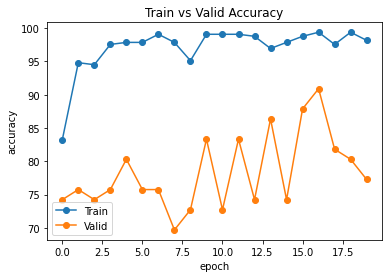

In [16]:
plt.plot(train_accuracy_ep,'-o')
plt.plot(val_accuracy_ep,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

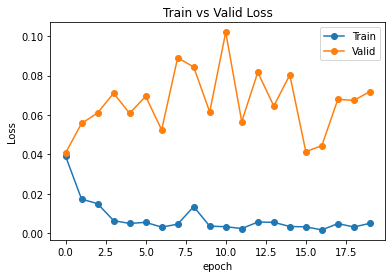

In [17]:
plt.plot(train_loss_ep,'-o')
plt.plot(val_loss_ep,'-o')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

In [18]:
y_pred.shape

(66, 3)

In [19]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [20]:
np.save("/content/drive/MyDrive/save_results/train_loss_ep.npy",train_loss_ep)
np.save("/content/drive/MyDrive/save_results/train_accuracy_ep.npy",train_accuracy_ep)
np.save("/content/drive/MyDrive/save_results/val_loss_ep.npy",val_loss_ep)
np.save("/content/drive/MyDrive/save_results/val_accuracy_ep.npy",val_accuracy_ep)
np.save("/content/drive/MyDrive/save_results/y_pred.npy",y_pred)
np.save("/content/drive/MyDrive/save_results/labels.npy",labels)

In [21]:
import numpy as np
pred=np.load('/content/drive/MyDrive/save_results/y_pred.npy')
label=np.load('/content/drive/MyDrive/save_results/labels.npy')

In [23]:
label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [22]:
pred

array([[3.68184358e-01, 2.29510918e-01, 4.02304739e-01],
       [9.93622482e-01, 1.56771019e-03, 4.80987364e-03],
       [9.99950290e-01, 3.94119098e-07, 4.93191365e-05],
       [9.63209271e-01, 7.54752895e-04, 3.60359326e-02],
       [9.99247313e-01, 9.58732562e-06, 7.43234588e-04],
       [9.96640086e-01, 6.35851961e-07, 3.35928751e-03],
       [9.99567807e-01, 5.61311481e-06, 4.26595885e-04],
       [9.91055489e-01, 2.49347650e-04, 8.69511161e-03],
       [9.99047458e-01, 1.47344384e-04, 8.05238669e-04],
       [9.99856591e-01, 1.67870639e-05, 1.26564628e-04],
       [9.96484637e-01, 4.06207300e-06, 3.51134385e-03],
       [9.99557316e-01, 1.59934862e-04, 2.82766210e-04],
       [9.99032855e-01, 8.50155720e-06, 9.58722027e-04],
       [9.93241310e-01, 2.04153298e-06, 6.75665215e-03],
       [9.85105038e-01, 7.21767094e-07, 1.48942154e-02],
       [7.14181423e-01, 8.45278701e-05, 2.85733998e-01],
       [9.99197781e-01, 4.28320142e-04, 3.73897754e-04],
       [4.97926325e-01, 4.83825

In [26]:
import numpy as np
pathP='/content/drive/MyDrive/save_results/y_pred.npy'
pathG='/content/drive/MyDrive/save_results/labels.npy'

In [30]:
import numpy as np
import os
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve

#     return dataparam
dataparam={"Accuracy":[],
           "Percision":[],
           "Recall":[],
           "F1_score":[],
           "class1_Accu":[],
           "class2_Accu":[],
           "class3_Accu":[],
           }
def performance(pathG,pathP):
    GT=np.load(pathG)
    Pred=np.load(pathP)
    Pred_arg=np.argmax(Pred,axis=1)
    y_true=GT
    y_pred=Pred_arg
    precision,recall,fscore,support=score(y_true,y_pred,average='macro')
    acc=accuracy_score(y_true, y_pred)
    conf_mat=confusion_matrix(y_true, y_pred)
    class_accuracy=conf_mat.diagonal()/conf_mat.sum(1)
    class1=class_accuracy[0]
    class2=class_accuracy[1]
    dataparam["Accuracy"].append(acc)
    dataparam["Percision"].append(precision)
    dataparam["Recall"].append(recall)
    dataparam["F1_score"].append(fscore)
    dataparam["class1_Accu"].append(class_accuracy[0])
    dataparam["class2_Accu"].append(class_accuracy[1])
    dataparam["class3_Accu"].append(class_accuracy[2])
    return dataparam
    
#D=os.path.join(pathresults,"GT_DensNet.npy","P_DensNet.npy"))
dataparam=performance(pathG,pathP)
 
df=pd.DataFrame.from_dict(dataparam)

result=df.rename(index={0: "ResNet"})

#result=df.rename(index={0: "Comined_Models", 
                        #1: "EFNetV1", 
                        #2: "VGG",
                        #3: "SENet",
                        #4: "mobilNe"})



result.to_csv("Results1.csv")

In [31]:
result

,Accuracy,Percision,Recall,F1_score,class1_Accu,class2_Accu,class3_Accu
ResNet,0.772727,0.821368,0.772727,0.754274,0.863636,0.454545,1.0


<Figure size 432x288 with 0 Axes>

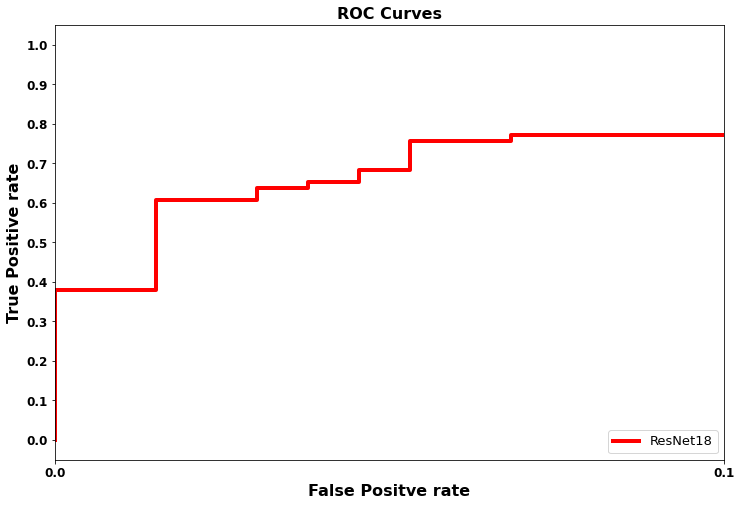

In [33]:
def performanceROC(pathG,pathP):
    GT=np.load(pathG)
    Pred=np.load(pathP)
    encoded_Gt = to_categorical(GT)
    #Pred_arg=np.argmax(Pred,axis=1)
    y_true=encoded_Gt.ravel()
    
    y_pred=Pred.ravel()
    return y_true,y_pred



y_true1,y_pred1=performanceROC(pathG,pathP)
#y_true2,y_pred2=performanceROC(pathresultse,"GT_Efficinet.npy","y_pred_Efficinet.npy")
#y_true3,y_pred3=performanceROC(pathresultsv,"GT_VGG11.npy","y_pred_VGG11.npy") 
#y_true4,y_pred4=performanceROC(pathresultss,"GT_SENet.npy","y_pred_SENet.npy") 
#y_true5,y_pred5=performanceROC(pathresultsm,"GT_MobileNet.npy","y_pred_MobileNet.npy") 
#y_true6,y_pred6=performanceROC(pathresultsm,"GT_MobileNet.npy","y_pred_MobileNet.npy")

def rocp(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    au = auc(fpr, tpr)
    return fpr, tpr, thresholds,au

fpr1, tpr1, thresholds1,auc1=rocp(y_true1, y_pred1)
#fpr2, tpr2, thresholds2,auc2=rocp(y_true2, y_pred2)
#fpr3, tpr3, thresholds3,auc3=rocp(y_true3, y_pred3)
#fpr4, tpr4, thresholds4,auc4=rocp(y_true4, y_pred4)
#fpr5, tpr5, thresholds5,auc5=rocp(y_true5, y_pred5)
#fpr6, tpr6, thresholds6,auc6=rocp(y_true6, y_pred6)

plt.figure(1)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(fpr1, tpr1,color='red', linestyle='-', linewidth=4.0,label= 'ResNet18')

#ax.plot(fpr2, tpr2,color='m',linestyle='--', linewidth=3.0,label= 'EfficientNet')
#ax.plot(fpr3, tpr3,marker='o',color='orange', markersize=3,linestyle= '-', linewidth=3.0,label= 'VGG')
#ax.plot(fpr4, tpr4,color='blue', linestyle='--',linewidth=3.0, label= 'SENET')
#ax.plot(fpr5, tpr5,color='cyan', linestyle='-', linewidth=3.0,label= 'MobileNet')

#ax.plot(fpr6, tpr6,color='green', linestyle='--',linewidth=3.0, label= 'Finetune_MobileNet')
################# 
plt.xticks(np.arange(0.0, 1.1, step=0.1),fontsize=12,fontweight='bold')
plt.xlabel('False Positve rate',fontsize=16,fontweight='bold')
plt.yticks(np.arange(0.0, 1.1, step=0.1),fontsize=12,fontweight='bold')
plt.ylabel('True Positive rate',fontsize=16,fontweight='bold')
#plt.title('ROC curve')
plt.title('ROC Curves', fontweight='bold', fontsize=16)
plt.xlim([0,0.1])
#plt.ylim([0,1.25])
plt.legend(prop={'size':13}, loc='lower right',fontsize=16)
#ax.legend(loc="bottom right",fontweight='bold')
plt.savefig('ResNet18.png',dpi=100)
plt.savefig("test.svg")

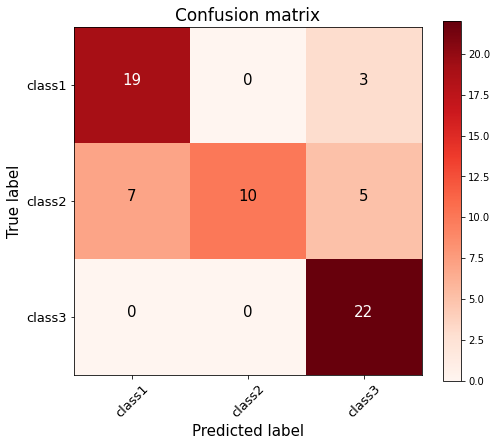

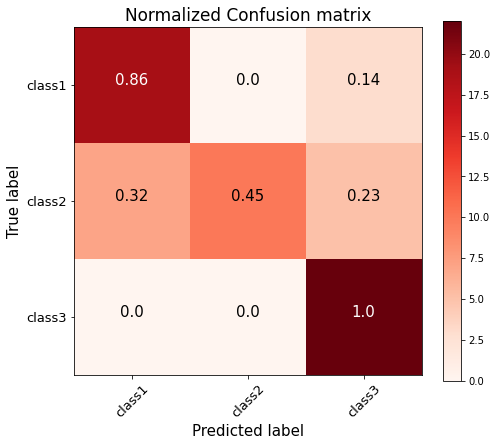

In [34]:
def performanceCM(pathG,pathP):
    GT=np.load(pathG)
    Pred=np.load(pathP)
    #encoded_Gt = to_categorical(GT)
    Pred_arg=np.argmax(Pred,axis=1)
    y_true=GT
    
    y_pred=Pred_arg
    return y_true,y_pred



y_true1,y_pred1=performanceCM(pathG,pathP)



# plot conum
y_test=y_true1
y_pred=y_pred1
classes= ['class1','class2','class3']

#Get the confusion matrix
import matplotlib.pyplot as plt
#cm = confusion_matrix(y_test3, y_pred2)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
import itertools
# fontweight='bold'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=13)
    plt.yticks(tick_marks, classes,fontsize=13)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix')
#fig1.savefig('../cm_wo_norm.jpg')
plt.show()

np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('cm_norm.jpg')
#plt.show()


In [37]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('Per class accuracy',class_accuracy)

Per class accuracy [ 86.36  45.45 100.  ]
